In [49]:
import pandas as pd
import re
import sklearn as sk
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# file management
import os
import sys

# nltk stuff
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')

# deep learning
import tensorflow as tf
import keras
from tensorflow.keras import layers
print(tf.config.list_physical_devices('GPU')) # check if gpu is detected

# visualization
import matplotlib.pyplot as plt
# tensorboard
%load_ext tensorboard


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


[nltk_data] Downloading package wordnet to /home/ashkan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ashkan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# preprocessing following paper

# 1)lowercase

# 2)tokenization

# 3)remove non-ascii tokens

# 4)rmeove punctuation

# 5)remove non-alpha-numeric characters

# 6)sub digits with words --> useless. I'll just change them to "NUM"

# 7)remove stopwords (NLTK)

# 8)lemmatization (NLTK)

In [31]:
# hyperparameters 
VOCAB_SIZE = 10000
MAX_TWEET_WORDS = 180 # max words in a 280 letter tweet is 180
# BATCH_SIZE = 64

In [16]:
# import data
df = pd.read_csv('./cybertweets/annotated.csv')
df = df.drop(['id'], axis = 1)
print(df.head(10))
print('annotations: ', df['annotation'].unique())
print('types:')
for unique_type in df['type'].unique():
    print(unique_type)

                                                text  annotation  \
0  Best way to build empathy is through honesty a...  irrelevant   
1  Cryptocurrency Scams Replacing Ransomware as A...    business   
2  Cryptocurrency Scams Replacing Ransomware as A...    business   
3  Protect  your customers  access Prestashop Ant...      threat   
4  Data leak from Huazhu Hotels may affect 130 mi...      threat   
5  Instagram App 41.1788.50991.0 #Denial Of #Serv...      threat   
6  (good slides): \n\nThe Advanced Exploitation o...      threat   
7  CVE-2018-1000532 (beep)\nhttps://t.co/CaKbo38U...      threat   
8  Will upload some of yesterday's videos which d...      threat   
9  Well you still protect them Ransomware Offline...    business   

                type  
0  ['Vulnerability']  
1     ['ransomware']  
2     ['ransomware']  
3           ['Ddos']  
4           ['leak']  
5        ['General']  
6  ['vulnerability']  
7  ['vulnerability']  
8           ['ddos']  
9     ['ransomware'] 

In [23]:
# preprocessing

def text_preprocessing(tweets_list):
    set_stopwords = set(stopwords.words('english'))

    for i, txt in enumerate(tweets_list):
        # lowercase
        txt = txt.lower()
        
        # replace stuff
        txt = re.sub('\b\S*[\x80-\xFF]\S*\b', '', txt) # any words with non-ascii characters
        txt = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'URL', txt) # urls
        txt = re.sub('(?<!\S)@([A-Za-z0-9_]+)(?!\S)', 'USER', txt) # usernames
        txt = re.sub('#\w+', 'HASHTAG', txt) # hashtags
        txt = re.sub('\b\d+\b', 'NUM', txt) # numbers
        txt = re.sub('[^\w\s]', '', txt) # punctuation

        # https://saturncloud.io/blog/reshaping-text-data-for-lstm-models-in-keras-a-comprehensive-guide/

        # tokenize
        # nltk handles all punctuation as features
        word_arr = re.split(f'\s+', txt) # returns list of words
    
        # remove stopwords and drop empty strings
        word_arr = [word for word in word_arr if word not in set_stopwords and len(word) != 0]
        
        # lemmatize
        lemmatizer = nltk.stem.WordNetLemmatizer()
        word_arr = [lemmatizer.lemmatize(word) for word in word_arr]

        if i % 10000 == 0: # log the processed message in specified intervals
            print(f"Processed text #{i}:", word_arr)
            print("---------------------------")

    tokenizer = keras.preprocessing.text.Tokenizer(num_words = VOCAB_SIZE) 
    print('fitting tokenizer...')
    tokenizer.fit_on_texts(tweets_list)
    print('tokenizing...')
    feature_vector = tokenizer.texts_to_sequences(tweets_list)

    # add padding and convert to numpy array
    print('padding sequences...')
    feature_vector = np.asarray(keras.preprocessing.sequence.pad_sequences(
            feature_vector,
            padding = 'post',
            maxlen = MAX_TWEET_WORDS,
    ))

    # DEBUG
    print(feature_vector)
    print('feature vector shape:', feature_vector.shape)

    return feature_vector

# preprocess annotations for initial binary classification
def annotation_preprocessing(annotation_list):
    # set all "threat" to 1, the rest to 0
    return np.asarray([1 if x == "threat" else 0 for x in annotation_list])

def train_valid_test_split(ds, train_ratio, valid_radio, batch_size):
    train_ratio = 0.8
    valid_ratio = 0.1
    init_len = len(model1_ds)
    num_train = np.floor(init_len * train_ratio)
    num_valid = np.floor(init_len * valid_ratio)

    train_ds = ds.take(num_train).batch(batch_size)
    valid_ds = ds.skip(num_train).take(num_valid).batch(batch_size)
    test_ds = ds.skip(num_train).skip(num_valid).batch(batch_size)
    
    print(f'train ds has {num_train} items in {len(train_ds)} batches.')
    print(f'valid ds has {num_valid} items in {len(valid_ds)} batches.')
    print(f'test ds has {init_len - num_train - num_valid} items in {len(test_ds)} batches.')

    return (train_ds, valid_ds, test_ds)

In [62]:
model1_data = text_preprocessing(df['text'])
model1_labels = annotation_preprocessing(df['annotation'])
print(model1_labels[:10])

# create tf dataset
model1_ds = tf.data.Dataset.from_tensor_slices((model1_data, model1_labels))
model1_train, model1_valid, model1_test = train_valid_test_split(model1_ds, 0.8, 0.1, 1)

Processed text #0: ['best', 'way', 'build', 'empathy', 'honesty', 'vulnerability']
---------------------------
Processed text #10000: ['leader', 'ddosforhire', 'gang', 'pleads', 'guilty', 'bomb', 'threat', 'URL', 'URL']
---------------------------
Processed text #20000: ['another', 'example', 'vulnerability', 'like', 'strut', 'effect', 'data', 'integrity', 'pii', 'protection', 'URL']
---------------------------
fitting tokenizer...
tokenizing...
padding sequences...
[[ 326  225    6 ...    0    0    0]
 [ 645 1445 2522 ...    0    0    0]
 [ 645 1445 2522 ...    0    0    0]
 ...
 [ 188  517   14 ...    0    0    0]
 [  15   45 1017 ...    0    0    0]
 [ 316  696   21 ...    0    0    0]]
feature vector shape: (21368, 180)
[0 0 0 1 1 1 1 1 1 0]
train ds has 17094.0 items in 17094 batches.
valid ds has 2136.0 items in 2136 batches.
test ds has 2138.0 items in 2138 batches.


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 180, 150)          1500000   
                                                                 
 conv1d_27 (Conv1D)          (None, 180, 32)           38432     
                                                                 
 max_pooling1d_27 (MaxPooli  (None, 90, 32)            0         
 ng1D)                                                           
                                                                 
 flatten_17 (Flatten)        (None, 2880)              0         
                                                                 
 dense_33 (Dense)            (None, 32)                92192     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                     

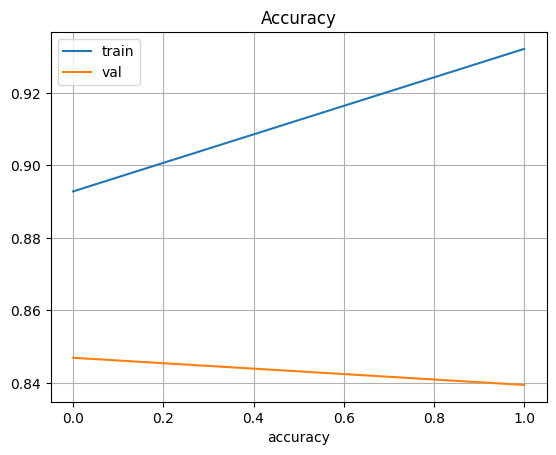

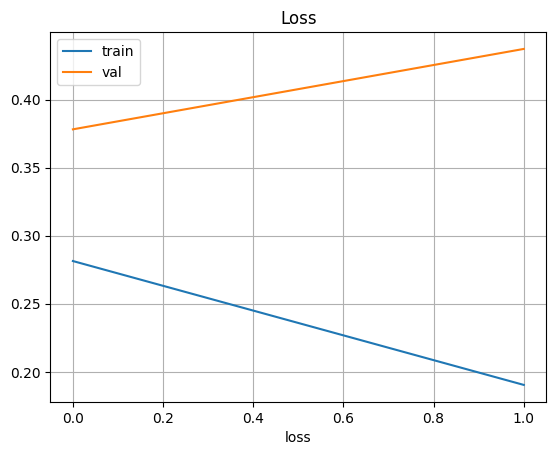

2138/2138 [==============================] - 9s 4ms/step - loss: 0.5909 - acc: 0.7521


[0.590908944606781, 0.7521047592163086]

In [65]:
# convolutional model??

model1 = keras.Sequential([
    layers.Embedding(VOCAB_SIZE, 150, input_length = MAX_TWEET_WORDS),
    # layers.LSTM(MAX_TWEET_WORDS),

    # conv layers --> following the paper
    layers.Conv1D(32, 8, activation = 'relu', padding = 'same'),
    layers.MaxPooling1D(2),
    
    # layers.Conv1D(32, 8, activation = 'relu', padding = 'same'),
    # layers.MaxPooling1D(2),

    layers.Flatten(),

    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation = 'sigmoid'),
])

model1.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = ['acc'],
)

print(model1.summary())
history = model1.fit(
    model1_train,
    validation_data = model1_valid,
    epochs = 2,
)

# plot losses over time
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.xlabel('accuracy')
plt.legend(['train','val'], loc='upper left')
plt.grid()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.xlabel('loss')
plt.legend(['train','val'], loc='upper left')
plt.grid()
plt.show()

# evaluate
model1.evaluate(model1_test)

In [ ]:
import sys
print(sys.version)